# I) Introduction to Neural Networks
from: https://www.python-course.eu/neural_networks.php

ANNs work the same way as neurons in the brain: they consists of many nodes (i.e. somas) that receive inputs from other nodes (i.e. dendrites). Every node has weights each input individually, then adds up the sum of all weighted inputs. If this value is above a certain threshold that is an attribute of the node, it will 'fire' to the next nodes (i.e. axons).

### 1. Building principle
The following code initializes a small neural network that performs an `AND` operator.

In [4]:
import numpy as np

class Perceptron:
    
    def __init__(self, input_length, weights=None):# If we call the class, we initiate a new incident with the attribute 'weights'
        if weights is None:
            self.weights = np.ones(input_length) * 0.5
        else:
            self.weights = weights
            
    @staticmethod
    def unit_step_function(x): # Check if value is higher than 0.5 (this is the threshold)
        if x > 0.5:
            return 1
        return 0
    
    def __call__(self, in_data): # Here, we multiply the weights with the input and take the sum (i.e. we compute the value of the node)
        weighted_input = self.weights * in_data
        weighted_sum = weighted_input.sum()
        return Perceptron.unit_step_function(weighted_sum) # Then we check if it is higher than 0.5
    
p = Perceptron(2, np.array([0.5,0.5])) # We initialize a neural network with 2 nodes, and each with a weight of 0.5

# Now we try different inputs
for x in [np.array([0,0]),np.array([1,0]),np.array([0,1]),np.array([1,1])]:
    y = p(x) # compute the output of the neural network with each input
    print(x, y)

[0 0] 0
[1 0] 0
[0 1] 0
[1 1] 1


### 2. Line separation
The following code initializes _and trains_ a NN to seperate two classes in a two-dimensional space. Each node represents one dimension.

The decision boundary of the NN is where $x_1w_1 + x_2w_2 = 0$

This again corresponds to $x_2 = -\frac{w_1}{w_2}x_1$ which is the function of a straight line through the origin.

In [75]:
from collections import Counter

class Perceptron:
    
    def __init__(self, input_length, weights=None):# If we call the class, we initiate a new incident with the attribute 'weights'
        if weights == None:
            self.weights = np.random.random((input_length)) * 2 - 1 # random number between -1 and 1 (from uniform dist)
        self.learning_rate = 0.1
            
    @staticmethod
    def unit_step_function(x): # Fire if value is at least 0
        if x < 0:
            return 0
        return 1
    
    def __call__(self, in_data): # Here, we multiply the weights with the input and take the sum (i.e. we compute the value of the node)
        weighted_input = self.weights * in_data
        weighted_sum = weighted_input.sum()
        return Perceptron.unit_step_function(weighted_sum) # Then we check if it is higher than 0.5
    
    def adjust(self, target, prediction, in_data): # Very basic learning function
        error = target - prediction
        for i in range(len(in_data)): # for each weight
            correction = error * in_data[i] * self.learning_rate
            self.weights[i] += correction # add to each weight the error weighted by the datapoint and the step size

            
points = np.random.randint(1, 100, (100, 2)) # generate some points to classify
def lin1(x): # line that separates/classifies the points
    return x + 4
def above_line(point, line_func): # this function classifies the points as being above the line (1) or below (0)
    x, y = point
    if y > line_func(x):
        return 1
    else:
        return 0


p = Perceptron(2) # initialize NN with two nodes

for point in points:
    p.adjust(above_line(point, lin1), p(point), point)

evaluation = Counter()
    
for point in points:
    if p(point) == above_line(point, lin1):
        evaluation['correct'] += 1
    else:
        evaluation['wrong'] += 1
        
print(evaluation.most_common()) # more wrong or more correct?

[('correct', 93), ('wrong', 7)]


In [19]:
# Let's see how good the decision boundary of our NN can distinguish between the classes 
# (in comparison to the true boundary)
%matplotlib inline 
from matplotlib import pyplot as plt

cls = [[], []]
for point in points:
    cls[above_line(point, lin1)].append(tuple(point))
colours = ("r", "b")

for i in range(2):
    X, Y = zip(*cls[i])
    plt.scatter(X, Y, c=colours[i])
    
X = np.arange(-3, 120)
    
m = -p.weights[0] / p.weights[1]
print('slope: ' + str(m))

plt.plot(X, m*X, label="ANN line")
plt.plot(X, lin1(X), label="line1")
plt.legend()
plt.show()

NameError: name 'points' is not defined

### 3. Linearly inseperable NNs
If a single line is not enough to separate two classes (for example in the XOR case), we need an additional 'hidden' layer.

### 4. Bias
In some cases, a line through the origin cannot separate two classes (e.g., when one class is scattered around the origin). In that case we need a __bias__ (i.e. an intercept). A bias is a node that does not receive any input - its output just depends on its weight.

$x_1w_1 + x_2w_2 + bw_3 = 0$

$x_2 = -\frac{w_1}{w_2}x_1 -\frac{w_3}{w_2}b$

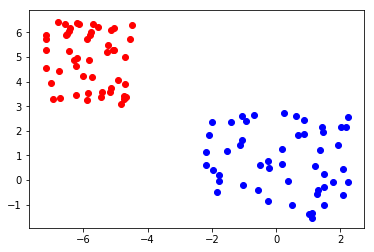

In [74]:
# Generate some data, that cannot be separated by a line through the origin
npoints = 50
X, Y = [], []
# class 0
X.append(np.random.uniform(low=-2.5, high=2.3, size=(npoints,)) )
Y.append(np.random.uniform(low=-1.7, high=2.8, size=(npoints,)))
# class 1
X.append(np.random.uniform(low=-7.2, high=-4.4, size=(npoints,)) )
Y.append(np.random.uniform(low=3, high=6.5, size=(npoints,)))
learnset = []
for i in range(2):
    # adding points of class i to learnset
    points = zip(X[i], Y[i])
    for p in points:
        learnset.append((p, i))
colours = ["b", "r"]
for i in range(2):
    plt.scatter(X[i], Y[i], c=colours[i])

In [79]:
# Define new class that takes into account bias:
class Perceptron:
    
    def __init__(self, input_length, weights=None):
        if weights==None:
            self.weights = np.random.random((input_length + 1)) * 2 - 1 # + 1 because bias needs a weight as well
        self.learning_rate = 0.05
        self.bias = 1 # define bias (number does not matter, I guess)
    
    @staticmethod
    def sigmoid_function(x): # sigmoid function as threshold (sigmoid is used as link function to fit betwenn 0 and 1)
        res = 1 / (1 + np.power(np.e, -x))
        return 0 if res < 0.5 else 1
        
    def __call__(self, in_data): # compute output and check if its above or below 0.5 in the sigmoid function
        weighted_input = self.weights[:-1] * in_data # no input for the bias
        weighted_sum = weighted_input.sum() + self.bias * self.weights[-1]
        return Perceptron.sigmoid_function(weighted_sum)
    
    def adjust(self, target, prediction, in_data):
        error = target - prediction
        for i in range(len(in_data)):
            correction = error * in_data[i] * self.learning_rate
            self.weights[i] += correction 
        correction = error * self.bias * self.learning_rate # correct bias
        self.weights[-1] += correction 

In [89]:
# Train NN:
p = Perceptron(2) # initialize NN

for point, label in learnset: # train NN
    p.adjust(label, p(point), point) 
    
evaluation = Counter() # evlauate NN
for point, label in learnset:
    if p(point) == label:
        evaluation["correct"] += 1
    else:
        evaluation["wrong"] += 1
print(evaluation.most_common())

[('correct', 100)]


30.56138278128663 84.63319115221464


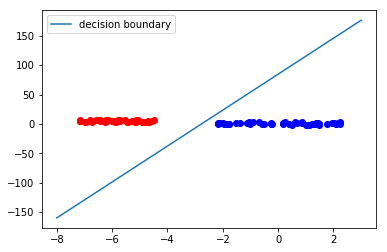

In [90]:
# Plot NN:
colours = ["b", "r"]
for i in range(2):
    plt.scatter(X[i], Y[i], c=colours[i])
XR = np.arange(-8, 4)  
m = -p.weights[0] / p.weights[1]
b = -p.weights[-1]/p.weights[1]
print(m, b)
plt.plot(XR, m*XR + b, label="decision boundary")
plt.legend()
plt.show()

# II) Neural Networks with Numpy
In the previous chapter, the NNs had only two layers (input and output). Now we will (a) add hidden layers that allow for more elaborate computations and (b) matrix algebra instead of loop structures to make the training process more efficient.


In [2]:
%%html
<img src='img/basic_NN.png', width = 500>

This image shows a simple NN with one hidden layer. Every arrow originating from a node is associated with a weight $w_{ij}$.

The nodes of the input layer ($i_1, i_2, i_3$) receive the input ($x_1, x_2, x_3$). The nodes of the hidden layer ($h_1$ to $h_4$) receive the weighted output of the nodes in the input layer (i.e. $Ih_1 = w_{11}i_1 + w_{12}i_2 + w_{13}i_3$).

With matrix algebra, this is much simpler. For the inputs for each of the nodes of the hidden layer we get $Ih = Wi$ (where the matrix $W$ is referred to as the weights-from-input-to-hidden (wih) matrix.

To obtain the input for the nodes in the output layer ($o_1, o_2$), we do the same thing ($Io = Wh$), but here the matrix $W$ comprises the weights-from-hidden-to-output-layer (who).

Additionally to these weighted inputs, each node has an activation function $\Phi$ that determines if the cell fires or not (i.e. the threshold).

### 1. Initializing weight matrices
Weights can be drawn from different distributions: uniform (`np.random.uniform`), binomial (`np.random.binomial`), or normal (in this case we need to truncate the distribution with `truncnorm`).

The best guess is to use a trucated normal with the interval ($-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}$)

In [11]:
# Initialize wih matrix
from scipy.stats import truncnorm
def truncated_normal(mean=0, sd=1, low=0, upp=10): # define easier function of truncnorm
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
no_of_input_nodes = 3
no_of_hidden_nodes = 4
rad = 1 / np.sqrt(no_of_input_nodes)
X = truncated_normal(mean=2, sd=1, low=-rad, upp=rad)
wih = X.rvs((no_of_hidden_nodes, no_of_input_nodes))
print('wih\n', wih)

# Initialize who matrix
no_of_hidden_nodes = 4
no_of_output_nodes = 2
rad = 1 / np.sqrt(no_of_hidden_nodes)  # this is the input in this layer!
X = truncated_normal(mean=2, sd=1, low=-rad, upp=rad)
who = X.rvs((no_of_output_nodes, no_of_hidden_nodes))
print('who\n', who)

wih
 [[ 0.26869904 -0.1775948   0.30350408]
 [-0.00808526  0.25183218  0.40446923]
 [-0.32093981  0.22857493  0.20449417]
 [-0.1226178   0.07397989  0.10411523]]
who
 [[ 0.11315844  0.09867007  0.4267691   0.22589845]
 [ 0.41463747  0.24378826  0.4630077  -0.05355038]]


In [15]:
# Set-up class for Neural Network
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate): # initalize NN instant with certain attributes
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes 
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate  
        self.create_weight_matrices() # for clarity, the weight matrix is added with an additional function (instead of defining it as an attribute now)
        
    def create_weight_matrices(self): # now we initialize the weight attribute of our NN
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes)) # initialize wih
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes)) # initialize who
    
    def train(self):
        pass
    
    def run(self):
        pass

In [16]:
# Initalize a NN
simple_network = NeuralNetwork(no_of_in_nodes = 3, no_of_out_nodes = 2, no_of_hidden_nodes = 4, learning_rate = 0.1)

# Check if it worked
print(simple_network.weights_in_hidden)
print(simple_network.weights_hidden_out)

[[-0.20605397  0.4089649  -0.47835099]
 [ 0.35447661  0.09931949  0.38219512]
 [ 0.01866045 -0.06313704 -0.45105711]
 [ 0.33257288 -0.49199553  0.22432326]]
[[-0.00244572 -0.18322861  0.45057527 -0.45832513]
 [-0.13078771 -0.47680078  0.36315299  0.03544602]]


### 2. Activation functions
As described above we not only need the weighed input, but also an activation function. This function defines if a neural fires based on a certain input (i.e. like a threshold). It basically defines how nodes handle the input they get.

One of the most often used activation functions is the sigmoid function:
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

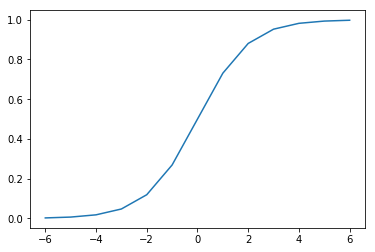

In [37]:
# Define sigmoid function:
@np.vectorize # vectorize sigmoid function to make it more compatible (?)
def sigmoid(x):
    return 1/(1+np.exp(-x))

#Plot it:
x = np.arange(-6,7)
plt.plot(x,sigmoid(x))
plt.show()

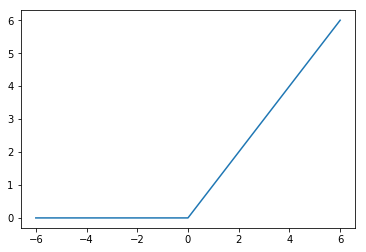

In [38]:
# Define ReLU function:
@np.vectorize
def ReLU(x):
    return np.maximum(0.0, x)

#Plot it:
x = np.arange(-6,7)
plt.plot(x,ReLU(x))
plt.show()

### 3. Computing output of NN
To compute the output, we add a method that takes the dot product of wih/who and the input vector, then runs this throgh the activation function.

In [34]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate): # initalize NN instant with certain attributes
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes 
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate  
        self.create_weight_matrices() # for clarity, the weight matrix is added with an additional function (instead of defining it as an attribute now)
        
    def create_weight_matrices(self): # now we initialize the weight attribute of our NN
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes)) # initialize wih
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes)) # initialize who
    
    def train(self):
        pass
    
    def run(self, input_vector):
        input_vector = np.array(input_vector, ndmin=2).T # transpose vector to one-column matrix
        output_vector = sigmoid(np.dot(self.weights_in_hidden, input_vector))        
        output_vector = sigmoid(np.dot(self.weights_hidden_out, output_vector))

        return output_vector

In [35]:
# Let's see if our NN can already compute something (the output is nonsensical, yet, because the weights are random)
simple_network = NeuralNetwork(no_of_in_nodes=2, no_of_out_nodes=2, no_of_hidden_nodes=10, learning_rate=0.6)
simple_network.run([(3, 4)])

array([[0.47388555],
       [0.52954811]])

### 4. Adding a training method
To train the weights of our NN, we go through two steps:

1) We compute the __output-error__ of our network (target minus output from output layer) -> This error determines how we update the __who__ weights

2) We compute the __hidden-error__ of our network (dot product of the wih weights and the outpur error) -> This error determines how we update the __wih__ weights

In [52]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate): # initalize NN instant with certain attributes
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes 
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate  
        self.create_weight_matrices() # for clarity, the weight matrix is added with an additional function (instead of defining it as an attribute now)
        
    def create_weight_matrices(self): # now we initialize the weight attribute of our NN
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes)) # initialize wih
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes)) # initialize who
    
    def train(self, input_vector, target_vector):
        # Transpose vectors:
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        # Compute output of hidden and output layer:
        output_vector_hidden = sigmoid(np.dot(self.weights_in_hidden, input_vector)) 
        output_vector_network = sigmoid(np.dot(self.weights_hidden_out, output_vector_hidden))
        
        # Compute output error:
        output_errors = target_vector - output_vector_network       
        # Update who weights:
        tmp = output_errors * output_vector_network * (1.0 - output_vector_network)     
        correction = self.learning_rate  * np.dot(tmp, output_vector_hidden.T)
        self.weights_hidden_out += correction
        
        # Compute hidden error:
        hidden_errors = np.dot(self.weights_hidden_out.T, output_errors) # why?       
        # Update wih weights:
        tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
        correction = self.learning_rate  * np.dot(tmp, input_vector.T)
        self.weights_in_hidden += correction
    
    def run(self, input_vector):
        input_vector = np.array(input_vector, ndmin=2).T # transpose vector to one-column matrix
        output_vector = sigmoid(np.dot(self.weights_in_hidden, input_vector))        
        output_vector = sigmoid(np.dot(self.weights_hidden_out, output_vector))

        return output_vector

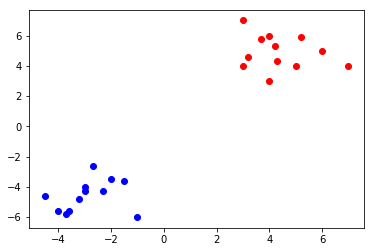

In [53]:
# Get some sample data
data1 = [((3, 4), (0.99, 0.01)), ((4.2, 5.3), (0.99, 0.01)), 
         ((4, 3), (0.99, 0.01)), ((6, 5), (0.99, 0.01)), 
         ((4, 6), (0.99, 0.01)), ((3.7, 5.8), (0.99, 0.01)), 
         ((3.2, 4.6), (0.99, 0.01)), ((5.2, 5.9), (0.99, 0.01)), 
         ((5, 4), (0.99, 0.01)), ((7, 4), (0.99, 0.01)), 
         ((3, 7), (0.99, 0.01)), ((4.3, 4.3), (0.99, 0.01))]
data2 = [((-3, -4), (0.01, 0.99)), ((-2, -3.5), (0.01, 0.99)), 
         ((-1, -6), (0.01, 0.99)), ((-3, -4.3), (0.01, 0.99)), 
         ((-4, -5.6), (0.01, 0.99)), ((-3.2, -4.8), (0.01, 0.99)), 
         ((-2.3, -4.3), (0.01, 0.99)), ((-2.7, -2.6), (0.01, 0.99)), 
         ((-1.5, -3.6), (0.01, 0.99)), ((-3.6, -5.6), (0.01, 0.99)), 
         ((-4.5, -4.6), (0.01, 0.99)), ((-3.7, -5.8), (0.01, 0.99))]
data = data1 + data2
np.random.shuffle(data)
points1, labels1 = zip(*data1)
X, Y = zip(*points1)
plt.scatter(X, Y, c="r")
points2, labels2 = zip(*data2)
X, Y = zip(*points2)
plt.scatter(X, Y, c="b")
plt.show()

In [64]:
# Try out NN
# Initialize NN:
simple_network = NeuralNetwork(no_of_in_nodes=2, no_of_out_nodes=2, no_of_hidden_nodes=2, learning_rate=0.6)

# Split training and test set:
size_of_learn_sample = int(len(data)*0.9)
learn_data = data[:size_of_learn_sample]
test_data = data[-size_of_learn_sample:]

# Train NN:
for i in range(size_of_learn_sample):
    point, label = learn_data[i][0], learn_data[i][1]
    simple_network.train(point, label)

# Check performance of NN:
for i in range(size_of_learn_sample):
    point, label = learn_data[i][0], learn_data[i][1] # get true belonging for every point
    cls1, cls2 = simple_network.run(point) # get probabilites of class belonging for every point
    print(point, cls1, cls2, end=": ")
    if cls1 > cls2: # i.e. if the prediction is class 1
        if label == (0.99, 0.01): # if true class is also class 1
            print("class1 correct", label)
        else: # but if the true class if class 2
            print("class2 incorrect", label)
    else: # if prediction is class 2
        if label == (0.01, 0.99):
            print("class2 correct", label)
        else:
            print("class1 incorrect", label)

(-4.5, -4.6) [0.32733766] [0.62502239]: class2 correct (0.01, 0.99)
(3, 7) [0.72545276] [0.37072564]: class1 correct (0.99, 0.01)
(3.7, 5.8) [0.72515205] [0.37095615]: class1 correct (0.99, 0.01)
(5.2, 5.9) [0.72537494] [0.37079687]: class1 correct (0.99, 0.01)
(5, 4) [0.72380942] [0.37202204]: class1 correct (0.99, 0.01)
(-3, -4.3) [0.32880088] [0.62406016]: class2 correct (0.01, 0.99)
(4.2, 5.3) [0.7249689] [0.37110218]: class1 correct (0.99, 0.01)
(3, 4) [0.722332] [0.37306245]: class1 correct (0.99, 0.01)
(4, 6) [0.72528109] [0.37086109]: class1 correct (0.99, 0.01)
(-3.2, -4.8) [0.32766706] [0.62482857]: class2 correct (0.01, 0.99)
(6, 5) [0.72510453] [0.37101554]: class1 correct (0.99, 0.01)
(7, 4) [0.72450888] [0.37150287]: class1 correct (0.99, 0.01)
(4.3, 4.3) [0.72396076] [0.3718827]: class1 correct (0.99, 0.01)
(-1, -6) [0.32733754] [0.62511217]: class2 correct (0.01, 0.99)
(-2.3, -4.3) [0.32956801] [0.62358312]: class2 correct (0.01, 0.99)
(-2.7, -2.6) [0.33994251] [0.61647

### 6. Adding bias
Bias makes each layer of the NN more flexible because it allows to add an additional weight that does not depend on the output.
Mathematically, adding a bias means that we get one more column of weights (in both wih and who matrices) and an additional '1' at the bottom of the input vector.

In [137]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate, bias=None): # initalize NN instant with certain attributes
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes 
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices() # for clarity, the weight matrix is added with an additional function (instead of defining it as an attribute now)
        
    def create_weight_matrices(self): # now we initialize the weight attribute of our NN
        bias_node = 1 if self.bias else 0 # bias or no bias?
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes + bias_node)) # initialize wih
        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes + bias_node)) # initialize who
    
    def train(self, input_vector, target_vector):
        bias_node = 1 if self.bias else 0 # bias or no bias?
        if self.bias:
            input_vector = np.concatenate( (input_vector, [self.bias]) ) # add '1' to input vector, so that matrix algebra makes sense
        
        # Transpose vectors:
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        # Compute output of hidden and output layer:
        output_vector_hidden = sigmoid(np.dot(self.weights_in_hidden, input_vector)) 
        if self.bias:
            output_vector_hidden = np.concatenate( (output_vector_hidden, [[self.bias]]) ) # again add '1' to 'input' vector
        output_vector_network = sigmoid(np.dot(self.weights_hidden_out, output_vector_hidden))
        
        # Compute output error:
        output_errors = target_vector - output_vector_network       
        # Update who weights:
        tmp = output_errors * output_vector_network * (1.0 - output_vector_network)     
        correction = self.learning_rate  * np.dot(tmp, output_vector_hidden.T)
        self.weights_hidden_out += correction
        
        # Compute hidden error:
        hidden_errors = np.dot(self.weights_hidden_out.T, output_errors) # why?       
        # Update wih weights:
        tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
        if self.bias: # cut-off the values for the bias agian (not used for correction?)
            correction = self.learning_rate  * np.dot(tmp, input_vector.T)[:-1,:]     
        else:
            correction = self.learning_rate  * np.dot(tmp, input_vector.T)
        self.weights_in_hidden += correction
    
    def run(self, input_vector):
        if self.bias:
            input_vector = np.concatenate( (input_vector, [self.bias]) ) # again, add '1' to input vector   
        input_vector = np.array(input_vector, ndmin=2).T # transpose vector to one-column matrix
            
        tmp = sigmoid(np.dot(self.weights_in_hidden, input_vector))
        if self.bias:
            tmp = np.concatenate( (tmp, [self.bias]) ) # add '1'
        output_vector = sigmoid(np.dot(self.weights_hidden_out, tmp))

        return output_vector

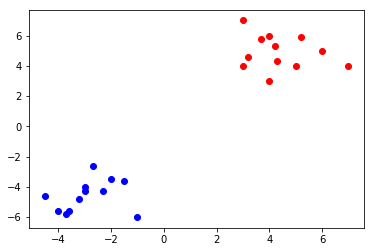

In [138]:
# Get some sample data
class1 = [(3, 4), (4.2, 5.3), (4, 3), (6, 5), (4, 6), (3.7, 5.8),
          (3.2, 4.6), (5.2, 5.9), (5, 4), (7, 4), (3, 7), (4.3, 4.3) ] 
class2 = [(-3, -4), (-2, -3.5), (-1, -6), (-3, -4.3), (-4, -5.6), 
          (-3.2, -4.8), (-2.3, -4.3), (-2.7, -2.6), (-1.5, -3.6), 
          (-3.6, -5.6), (-4.5, -4.6), (-3.7, -5.8) ]
labeled_data = []
for el in class1:
    labeled_data.append( [el, [1, 0]])
for el in class2:
    labeled_data.append([el, [0, 1]])
  
np.random.shuffle(labeled_data)
data, labels = zip(*labeled_data)
labels = np.array(labels)
data = np.array(data)

# Plot
X, Y = zip(*data[labels[:,0] == [1]])
plt.scatter(X, Y, c="r")
X, Y = zip(*data[labels[:,1] == [1]])
plt.scatter(X, Y, c="b")
plt.show()

In [141]:
# Try out NN
simple_network = NeuralNetwork(no_of_in_nodes=2, no_of_out_nodes=2, no_of_hidden_nodes=10, learning_rate=0.1, bias=None)

# Train network, now with 20 steps
for _ in range(20):
    for i in range(len(data)):
        simple_network.train(data[i], labels[i])

# Check performance
for i in range(len(data)):
    print(labels[i])
    print(simple_network.run(data[i]))

array([[-0.23487334,  0.03264907, -0.15125145,  0.18331348, -0.1433451 ,
        -0.16018008,  0.1649282 , -0.10700688, -0.16627752, -0.3022884 ],
       [-0.07122187, -0.06642894,  0.08202864,  0.21529248, -0.14903894,
        -0.31378341, -0.25019345,  0.0261261 , -0.1632714 , -0.15260307]])

In [145]:
data[1]
simple_network.weights_in_hidden

array([[-0.66650204, -0.04795117],
       [-0.31801379,  0.43679007],
       [ 0.51270481,  0.61093862],
       [-0.13417574,  0.61116797],
       [-0.0749294 , -0.07344435],
       [-0.19670513, -0.26068466],
       [ 0.67678246,  0.55717782],
       [-0.4538173 ,  0.40636022],
       [-0.21230318,  0.02976943],
       [ 0.12909007,  0.2247982 ]])

# III) Backpropagation
### 1. The first step
To improve our NN, i.e. to train it, we need to adjust every weight individually. But how do we update each weight? We look at the derivative of the cost function $C_0$ with respect to each weight $w_{ij}$. This means we look at how much the cost function changes if we adjust a certain weight in a certain direction.
$$ \frac{\partial{C_0}}{\partial{w^{(L)}_{ij}}} $$
$$ C_0 = \sum(a^{(L)}_j - y_j)^2 $$

So, how does a weight influence the cost function? The cost function describes the difference between what our NN predicts and what it should predict (i.e. the target). The prediction of our model is the activation of an output node. The activation of an ouput node depends on the input is gets from another (hidden) node. And the input finally depends on the weight. In summary, we have a whole chain of dependencies that each influence a further step. So, to see how a weight influences the cost function, we need to look at how the weight influence the input, how the input inlfuence the activation and how the activation finally influences the cost function:
$$ \frac{\partial{C_0}}{\partial{w^{(L)}_{ij}}} = \Big(\frac{\partial{C_0}}{\partial{a^{(L)}_j}}\Big) \Big(\frac{\partial{a^{(L)}_j}}{\partial{z^{(L)}_j}}\Big) \Big(\frac{\partial{z^{(L)}_j}}{\partial{w^{(L)}_{ij}}}\Big) $$

- A unit change of the activation of an output node results in a two unit change of the cost function:
$$ \frac{\partial{C_0}}{\partial{a^{(L)}_j}} = 2(a^{(L)}_j - y_j) $$ 

- The effect of a unit change depends on the derivation of the activation function $g'^{(L)}$:
$$ \frac{\partial{a^{(L)}_j}}{\partial{z^{(L)}_j}} = g'^{(L)}(z^{(L)}_j) $$

- A unit change of a weight results in a unit change of the input:
$$ \frac{\partial{z^{(L)}_j}}{\partial{w^{(L)}_{ij}}} = a^{(L-1)}_i $$

$$ \frac{\partial{C_0}}{\partial{w^{(L)}_{ij}}} = 2(a^{(L)}_j - y_j) (g'^{(L)}(z^{(L)}_j)) (a^{(L-1)}_i) $$

Finally, we do this with many training examples (either all or batches) and take the average change of the cost function to update a weight. This we do for every weight in the network.

### 2. The backward movement

To update the weights from the last hidden layer, we do almost the same thing - just with $(L-1)$ instead of $(L)$. The difference is, however, that the cost function $C_0$ is no direct function of the activation $a_j^{(L-1)}$ (so, basically, we only have to change something about how we compute the first term).
$$ \frac{\partial{C_0}}{\partial{w^{(L-1)}_{ij}}} = \Big(\frac{\partial{C_0}}{\partial{a^{(L-1)}_j}}\Big) \Big(\frac{\partial{a^{(L-1)}_j}}{\partial{z^{(L-1)}_j}}\Big) \Big(\frac{\partial{z^{(L-1)}_j}}{\partial{w^{(L-1)}_{ij}}}\Big) $$

To compute the first term (how the activation of a node in the hidden layer changes to cost of the whole network), we again use a very similar differentiation of the derivation. The only difference is in the last term, where we take the derivative of the input to node j in the output layer with respect to the _activation_ of node j in the previous layer. Additionally, we take the sum of all nodes in the output layer, because the activation in one of the nodes in the preivious layer affect all of them.

$$ \frac{\partial{C_0}} {\color{red}{\partial{a^{(L-1)}_j}}} = \color{red}{\sum_{j=0}^{n-1}}\Big(\frac{\partial{C_0}}{\partial{a^{(L)}_j}}\Big) \Big(\frac{\partial{a^{(L)}_j}}{\partial{z^{(L)}_j}}\Big) \Big(\frac{\partial{z^{(L)}_j}}{\partial{\color{red}{a^{(L-1)}_{j}}}}\Big) $$

This means we end up with:

$$ \frac{\partial{C_0}}{\color{red}{\partial{a^{(L-1)}_j}}} = \color{red}{\sum_{j=0}^{n-1}}2(a^{(L)}_j - y_j) (g'^{(L)}(z^{(L)}_j)) \color{red}{(w^{(L)}_{ij})} $$

In summary, we need the weights of the next layer to update the weights of a previous layer - we have to move backwards

### 3. Derivation of the activation function
So far, we've only spoken about $g'(x)$ as the derivation of the activation function. If we use the sigmoid function as activation function, the derivation is:
$$ \frac{\partial\sigma(z^{(L)}_j)}{\partial z^{(L)}_j} = \sigma(z^{(L)}_j)(1-\sigma(z^{(L)}_j)) $$

This means for a __who__ weight we get the updates:
$$ w^{(L)}_{ij} = w^{(L)}_{ij} + \eta * (a^{(L)}_j - y_j) (\sigma(z^{(L)}_j)(1-\sigma(z^{(L)}_j))) (a^{(L-1)}_i) $$

And for the __wih__ weights we get the updates:
$$ w^{(L)}_{ij} = w^{(L)}_{ij} + \eta * \sum_{j=0}^{n-1}\Big((a^{(L)}_j - y_j) (\sigma(z^{(L)}_j)(1-\sigma(z^{(L)}_j)))(w^{(L)}_{ij})\Big) $$

In [136]:
# Backpropagation with one hidden layer but without bias:
    def train(self, input_data, target):
        
        # Transpose vectors:
        input_data = np.array(input_data, ndmin=2).T
        target = np.array(target, ndmin=2).T
        
        # Compute output of hidden and output layer:
        output_hidden = sigmoid(np.dot(self.weights_in_hidden, input_data)) 
        output_network = sigmoid(np.dot(self.weights_hidden_out, output_hidden))
        
        # Update who weights:
        correction = self.step_size * ((target - output_network) * output_network * (1.0 - output_network)) @ output_hidden
        self.weights_hidden_out += correction
        
        # Update wih weights:
        correction = self.step_size * ((self.weights_hidden_out.T @ (target - output_network)) * output_network * (1.0 - output_network)) @ input_data      
        self.weights_in_hidden += correction

# IV) Accuracy
To evaluate how well a NN performs, we have to compare the true classes to the corresponding predicted classes. This comparison can be done using a __confusion matrix__; It displays true classes of each instance in rows and the predicted classes for each instance in columns.
From the confusin matrix, we can compute several performance measures:
- Accuracy: $ \frac{TN + TP}{TN + FN + TP + FP}$
- Recall (true positive rate): $ \frac{TP}{FN + TP}$
- True negative rate: $ \frac{TN}{FP + TN}$
- Precision: $ \frac{TP}{FP + TP}$

For more than two classes:
- Recall$_i$: $ \frac{M_{ii}}{\sum_i M_{ij}}$
- Precision$_i$: $ \frac{M_{ii}}{\sum_j M_{ij}}$

# V) Overfitting
A simple way to prevent NN from overfitting is a technique called __dropout__. Here, we randomly pick nodes in every layer and deactivate them. Mathematically, we can deactivate input nodes by setting one column of the wih weight matrix to zero. And we can deactivate hidden nodes by setting one row of the wih matrix and one column of the next wih or who matrix to zero.

We use the chosen nodes for one epoch, and then take a different set for the next one.

# VI) Pipeline
1) How many layers and nodes do I need?

2) Get network with 2 hidden layers to run (especially training algorithm)

3) Expand network to 784 input nodes and 800 nodes per hidden layer

4) Dropout?

5) Check results and make more efficient